# Analyzing U-V/V-J color-color diagram for COSMOS field using 3D-HST catalogs

In this project, we work with 3D-HST data in COSMOS field. We hope to demonstrate some standard practices in astronomy. This notebook might be useful for folks begining their research in extragalactic astronomy as well as people who are interested to see some standard data visualization/fitting techniques applied to real world, noisy, astronomical data sets.

You should read and cite relevant data release papers for more information ([Momcheva et. al. (2016)](https://arxiv.org/pdf/1510.02106.pdf), [Brammer et. al. (2012)](https://arxiv.org/pdf/1207.3795.pdf)). The goal is to analyze the color of galaxies in distant universe, and connect it with the underlying parameters.

We have two main parts in this notebook. In part 1, we clean and visualize the data and go over some useful techniques. In part 2, we fit a few models to the cleaned data set.

# Part 1: Cleaning and Visualizing data

We first begin by importing what we need. 

In [1]:
# Core python packages
import numpy as np
import pandas as pd
import os
from itertools import combinations
pd.options.mode.chained_assignment = None

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn for fitting different models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.tree import export_graphviz
from IPython.display import Image

Astronomical data sets come in many formats. One usual format is a catalog, that is a table that lists different measurements for different astronomical objects. We strongly encourage you to open these files with a text editor first. In each one of the files, we have quite a few lines start with #. These are comments left by people who made the catalog. The most important line is the first, where we find the description of each row.

In [2]:
# We first read numerical contents using genfromtxt. You may want to try open_csv from pandas, 
# but due to unusual formatting of the comment lines, it should not work automatically. 

colors_arr = np.genfromtxt('cosmos_3dhst.v4.1.master.RF') # Contains color
stellarpop_arr = np.genfromtxt('cosmos_3dhst.v4.1.fout') # Contains physical parameters of galaxies 
sfr_arr = np.genfromtxt('cosmos_3dhst.v4.1.sfr') # Contains star-formation rates as measured from fluxes

# To access the name of each column above, we read the first line of the file,
# adding anything that is not empty, space or # to a list
with open('cosmos_3dhst.v4.1.master.RF') as fhandle:
    colors_names = [_ for _ in fhandle.readline().rstrip().split(' ') if (_!='' and _!='#')]

with open('cosmos_3dhst.v4.1.fout') as fhandle:
    stellarpop_names = [_ for _ in fhandle.readline().rstrip().split(' ') if (_!='' and _!='#')]

with open('cosmos_3dhst.v4.1.sfr') as fhandle:
    sfr_names = [_ for _ in fhandle.readline().rstrip().split(' ') if (_!='' and _!='#')]

# Now we initiata Data Frames (pandas)
colors_df = pd.DataFrame(data=colors_arr, columns=colors_names)
stellarpop_df = pd.DataFrame(data=stellarpop_arr, columns=stellarpop_names)
sfr_df = pd.DataFrame(data=sfr_arr, columns=sfr_names)

# We have three sets of files each measuring different parameters for each astronomical object (galaxy)
# If you take a look, you notice that each astronomical object has a unique id. We use that to merge all
# Data Frames.
full_df = pd.merge(pd.merge(sfr_df, stellarpop_df, on='id'), colors_df, on='id')

full_df['lsfr_FAST']=full_df['lsfr']
full_df['lsfr'] = np.log10(full_df['sfr'])
full_df['lssfr'] = np.log10(full_df['sfr'])-full_df['lmass']

/Users/mohammadakhshik/anaconda3/envs/astroconda/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In the last three lines we copy what we already have for the paremeter "lsfr" (which is the lograithm of star-formation rate) into a new column "lsfr_FAST", as these values are measured using the FAST software ([Kriek et. al. (2016)](https://arxiv.org/pdf/0905.1692.pdf)). We then replace lsfr column with the lograithm of the sfr column. The reason is that star-formation rates in the "sfr" column are measured using a different appraoch, which we would like to use in the following analysis ([Whitaker et. al. (2014)](https://arxiv.org/pdf/1407.1843.pdf)). By copying "lsfr" into "lsfr_FAST", we avoid overwriting it completey, because we may have to use it at some point. 

We finally calculate another parameter "lssfr" using its definition. Please note that "lmass" is the logairthm if the stellar mass of each galaxy.

Next we look at a few columns at the beginning of the data set. Also, please note the warning above. Apparently, logarithm encounters some negative numbers.

In [3]:
full_df.head(10)

,id,sfr,sfr_IR,sfr_UV,L_IR,L_UV,flag,z_x,z_type,f24tot,...,n_271,L272,n_272,L273,n_273,L274,n_274,L275,n_275,lsfr_FAST
0,1.0,3.5641,3.5288,0.035338,3.237400e+10,1.473600e+08,0.0,0.8855,1.0,81.110,...,14.0,0.041852,20.0,0.044573,22.0,0.047992,23.0,2.022350,17.0,-99.00
1,2.0,2.1549,2.0935,0.061408,1.920600e+10,2.560800e+08,0.0,0.8855,1.0,48.120,...,14.0,0.081264,20.0,0.076042,22.0,0.083398,23.0,2.368360,17.0,-99.00
2,3.0,2.4916,1.3982,1.093500,1.282700e+10,4.559900e+09,0.0,0.8131,2.0,36.060,...,14.0,0.801173,17.0,1.551970,22.0,1.761980,22.0,32.525000,17.0,-0.45
3,4.0,306.9600,305.1900,1.769300,2.799900e+12,7.378000e+09,0.0,3.0885,2.0,113.800,...,32.0,0.205121,36.0,0.240214,35.0,0.243056,33.0,3.000490,8.0,0.23
4,5.0,-99.0000,-99.0000,0.003319,-9.900000e+01,1.384300e+07,2.0,0.5092,2.0,-8.207,...,8.0,0.013555,11.0,0.014446,15.0,0.013915,16.0,0.127147,18.0,-99.00
5,6.0,-99.0000,-99.0000,0.007617,-9.900000e+01,3.176200e+07,2.0,0.8522,2.0,-4.366,...,14.0,0.007499,17.0,0.010426,22.0,0.011169,22.0,0.206435,18.0,-13.01
6,7.0,-99.0000,-99.0000,0.271940,-9.900000e+01,1.134000e+09,2.0,1.6177,2.0,-16.830,...,24.0,0.036765,26.0,0.086299,27.0,0.115616,27.0,3.038270,13.0,-99.00
7,8.0,-99.0000,-99.0000,0.040645,-9.900000e+01,1.695000e+08,2.0,1.5069,2.0,-46.400,...,22.0,0.012570,25.0,0.018350,26.0,0.019714,26.0,0.378224,14.0,-30.14
8,9.0,-99.0000,-99.0000,0.084301,-9.900000e+01,3.515500e+08,2.0,1.4098,2.0,-3.322,...,22.0,0.024789,24.0,0.040862,26.0,0.046332,26.0,0.798237,15.0,-11.29
9,10.0,-99.0000,-99.0000,0.799710,-9.900000e+01,3.334900e+09,2.0,1.9080,2.0,-20.330,...,25.0,0.040366,26.0,0.211900,31.0,0.251721,31.0,5.059070,14.0,-99.00


## Data Selection

We notice that we have many -99.0 in our "sfr" column among others. These values indicate that the parameter of interest could not be determined for the object. Some folks use NaN too. We decide to get rid of them to clean our sample. We also would like to study distant galaxies. One way to pick them is to use [redshift](https://en.wikipedia.org/wiki/Redshift), indicated by "z_x" column here. We selected galaxies that are between redshitf of 1 and 3. We are finally interested to study massive galaxies here, therefore we pick "lmass">10 here.

In [4]:
redshift_selection = (full_df['z_x'] > 1.0) & (full_df['z_x'] < 3.0) # Redshift selection
clean_selection = (full_df['sfr'] > 0) # Cleaning data by removing -99 sfr
physical_selection = (full_df['lmass'] > 10.0) # selectin massive galaxies

all_selection = redshift_selection & clean_selection & physical_selection # all selection rules combined

# We finally calculate the fraction of galaxies selected using each condition and their combination.
print('redshift selection fraction: {0:1.2f}'.format(redshift_selection.sum()/len(full_df)))
print('cleaning selection fraction: {0:1.2f}'.format(clean_selection.sum()/len(full_df)))
print('physical selection fraction: {0:1.2f}'.format(physical_selection.sum()/len(full_df)))
print('all selections fraction: {0:1.2f}'.format(all_selection.sum()/len(full_df)))

full_df = full_df[all_selection]

redshift selection fraction: 0.46
cleaning selection fraction: 0.55
physical selection fraction: 0.10
all selections fraction: 0.04


As you can see, the most constraining INDIVIDUAL selection rule is stellar mass. When we combined all our selection rules, only 4% of galaxies remain! This means that the massive galaxies at distant universe that also have a reliable measurement of star-formation rate are not common in 3D-HST.

We next calculate U-V and V-J colors and add them as columns. [Colors](https://en.wikipedia.org/wiki/Color_index) are important parameters in observational astronomy. They are relatively easy to measure and often correlated with many interesting underlying physical parameters.

In [5]:
full_df['uv'] = -2.5*np.log10(full_df['L153']/full_df['L155'])
full_df['vj'] = -2.5*np.log10(full_df['L155']/full_df['L161'])

In [6]:
full_df.head(10)

,id,sfr,sfr_IR,sfr_UV,L_IR,L_UV,flag,z_x,z_type,f24tot,...,n_272,L273,n_273,L274,n_274,L275,n_275,lsfr_FAST,uv,vj
11,12.0,2.3490,2.12810,0.22085,1.952400e+10,9.209700e+08,1.0,1.7572,2.0,7.978,...,26.0,0.066030,30.0,0.080679,31.0,2.54827,13.0,-7.85,2.009072,0.984835
24,25.0,7.7852,6.55470,1.23050,6.013500e+10,5.131200e+09,1.0,1.3683,2.0,27.950,...,24.0,0.623985,26.0,0.715556,26.0,12.56360,15.0,-1.08,1.576741,0.875288
73,74.0,147.4000,145.19000,2.21060,1.332000e+12,9.218400e+09,0.0,2.0904,2.0,384.400,...,30.0,0.556789,32.0,0.591334,32.0,4.33861,14.0,1.18,1.268781,1.703062
105,106.0,1.0385,0.18132,0.85718,1.663500e+09,3.574600e+09,1.0,1.2449,2.0,1.184,...,24.0,0.519503,25.0,0.596948,26.0,19.13760,17.0,-0.71,1.978367,1.242262
118,119.0,64.6360,61.21700,3.41920,5.616200e+11,1.425900e+10,0.0,1.7360,2.0,226.900,...,26.0,1.203170,30.0,1.277030,31.0,7.14485,13.0,0.72,1.061159,1.055635
136,137.0,147.1200,145.70000,1.41440,1.336700e+12,5.898100e+09,0.0,1.7013,2.0,525.500,...,26.0,0.474676,28.0,0.548107,31.0,9.78509,13.0,-2.73,1.648887,2.147360
138,139.0,87.6130,84.04300,3.57020,7.710400e+11,1.488800e+10,0.0,2.7339,2.0,64.480,...,32.0,0.567215,36.0,0.600963,35.0,4.84754,9.0,1.77,1.367663,1.805949
150,151.0,12.7720,10.35800,2.41400,9.503100e+10,1.006700e+10,0.0,1.8674,2.0,37.380,...,26.0,0.628533,31.0,0.789839,31.0,167.04000,15.0,-99.00,2.766470,-0.175581
162,163.0,335.6100,331.46000,4.15280,3.040900e+12,1.731800e+10,0.0,2.3216,2.0,622.000,...,31.0,0.867393,33.0,0.924450,33.0,6.74109,13.0,1.21,1.218150,1.603382
203,204.0,54.6110,50.47500,4.13630,4.630700e+11,1.724900e+10,0.0,2.0926,2.0,133.200,...,30.0,1.059960,32.0,1.104430,32.0,5.06822,14.0,1.04,0.988122,1.015731


Next, we make some plots to inspect the data. We have many columns in our full data frame and we are not interested to know about many of them in this specific analysis. Therefore, we use seaborn pairplot to only see a scatter plot of a few parameters that are relevant in the subsequqnt analyses (using vars argument). It's always a good idea to make similar plots.

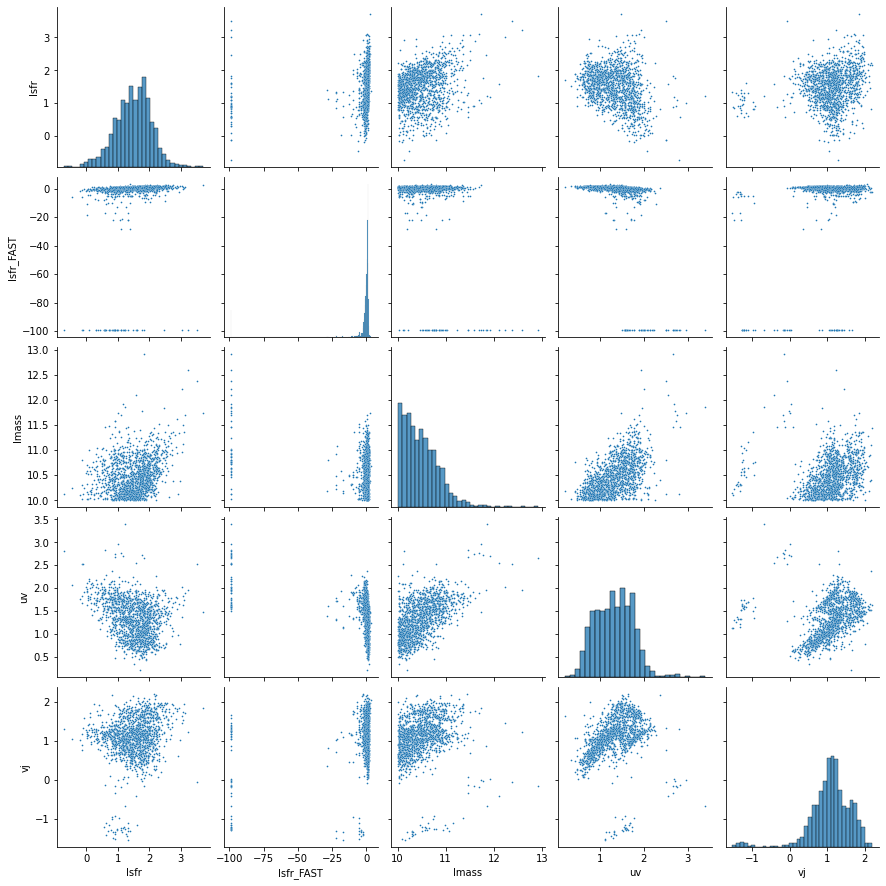

In [7]:
sns.pairplot(full_df, vars=['lsfr', 'lsfr_FAST', 'lmass', 'uv', 'vj'], kind='scatter', plot_kws={'s': 3})

As we see, "lsfr_FAST" column still has many -99.0 values even though we have removed -99.0 using "sfr" column. The reason is that star-formation rate is calculated using different methods and it is generally more robust using the second method. We also see many hints for slight correlation among parameters. That's encouraging! To have a better look, we remove "lsfr_FAST" from our plot and use a kde-plot.

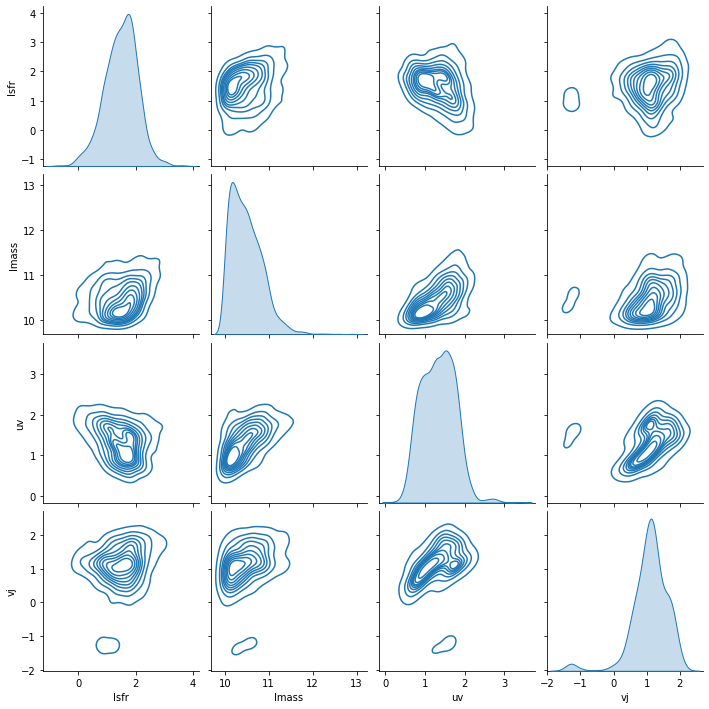

In [8]:
sns.pairplot(full_df, vars=['lsfr', 'lmass', 'uv', 'vj'], kind='kde')

We are particularly interested in vj/uv subpanel. It looks like we have two distributions here. Let's take a closer look.

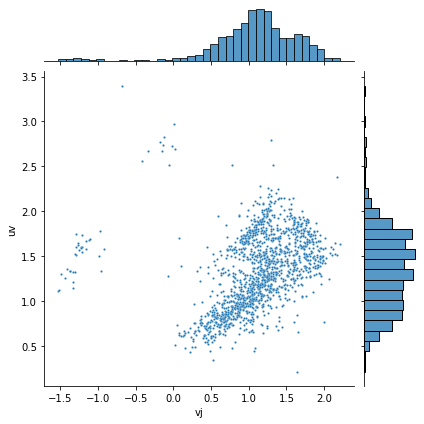

In [9]:
sns.jointplot(x=full_df['vj'], y=full_df['uv'], s=5)

We have many outliers with negative vj values. We can remove them to clean the plot up a bit.

In [10]:
positive_vj_selection = full_df['vj']>0
print('Negative V-J fraction: {0:1.2f}'.format(1-positive_vj_selection.sum()/len(full_df)))
full_df = full_df[positive_vj_selection]

Negative V-J fraction: 0.03


Another interesting and quite common approach is to color code a scatter plot with a third parameter. Let's select "lssfr". We first make a histogram plot of "lssfr" to check the distribiution, mostly interested to see if there is any weird featutres/outliers. Then, use that as a color.

Text(0.5, 0, 'lssfr')

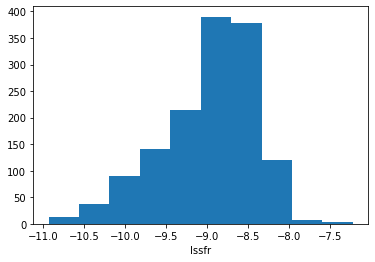

In [11]:
plt.hist(full_df['lssfr'])
plt.xlabel('lssfr')

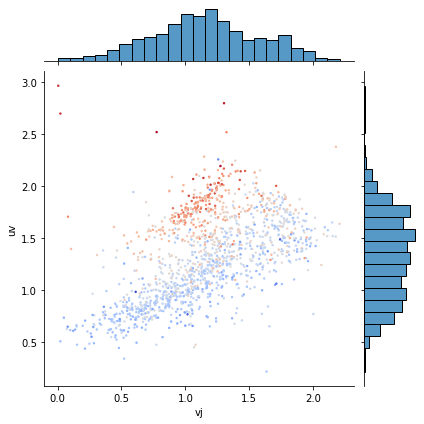

In [12]:
_plt_obj=sns.jointplot(x=full_df['vj'], y=full_df['uv'], s=0)
_plt_obj.ax_joint.scatter(full_df['vj'], full_df['uv'], s=2, c=full_df['lssfr'], cmap='coolwarm_r')

Interestingly, it looks like that one of the distribtuon in UV/VJ plot has also a lower relative value of lssfr, i.e. it is less star-forming. This is an interesting observation, indicating that these two separate populations in color-color space have diffenet physical parameters (e.g. [Whitaker et. al. (2012)](https://arxiv.org/pdf/1105.4609.pdf)). Usually the population that is color coded with red is called quiescent and the population color coded with blue is called star forming.

To investigate this a bit more, we make the famous SFR/stellar mass correlation plot next.

Text(0, 0.5, 'lsfr')

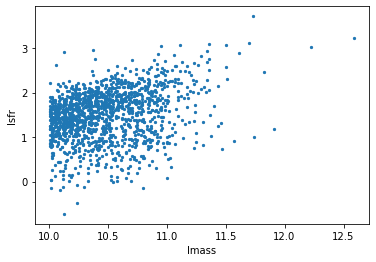

In [13]:
plt.scatter(full_df['lmass'], full_df['lsfr'], s=5)
plt.xlabel('lmass')
plt.ylabel('lsfr')

# Part 2: Fitting
In this part, we investigate SFR/stellar mass correlation. We also try to fit different models to quiescent/star-forming galaxies in UV/VJ color-color space to see how well we are able to separate these populations using their colors.

The slope is 0.47
The intercept is -3.43


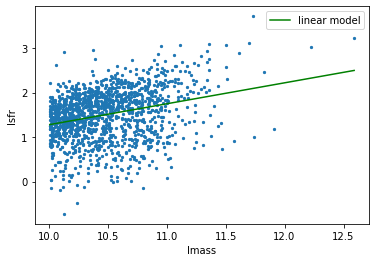

In [14]:
X = full_df['lmass'].to_numpy()[:, None]
y = full_df['lsfr'].to_numpy()

# We first fit a linear model
sfr_mass_linear = LinearRegression() 
sfr_mass_linear.fit(X, y)

X_arr = np.linspace(X.min(), X.max(), 100)
y_pred_linear = sfr_mass_linear.predict(X_arr[:, None])

plt.scatter(X[:,0], y, s=5)
plt.plot(X_arr, y_pred_linear, color='green', label='linear model')
plt.legend()
plt.xlabel('lmass')
plt.ylabel('lsfr')

print('The slope is {0:1.2f}'.format(sfr_mass_linear.coef_[0]))
print('The intercept is {0:1.2f}'.format(sfr_mass_linear.intercept_))

The coefficients are -2.41, 0.14
The intercept is 11.86


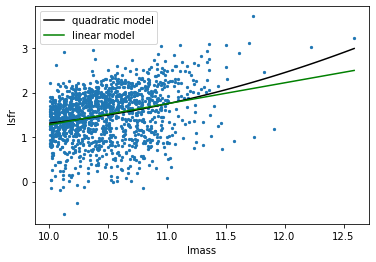

In [15]:
# Whitaker et. al. (2014) suggested a second degree polynomial fit. We use PolynomialFeatures
# in a scikit-learn Pipeline to fit that model to the data.

quad_model = Pipeline([('poly_transform', PolynomialFeatures(degree=2, include_bias=False)),
                 ('linear_fit', LinearRegression())])

quad_model.fit(X, y)
y_pred_quad = quad_model.predict(X_arr[:, None])

plt.scatter(X[:,0], y, s=5)
plt.plot(X_arr, y_pred_quad, color='black', label='quadratic model')
plt.plot(X_arr, y_pred_linear, color='green', label='linear model')
plt.legend()
plt.xlabel('lmass')
plt.ylabel('lsfr')

print('The coefficients are {0:1.2f}, {1:1.2f}'.format(*quad_model['linear_fit'].coef_))
print('The intercept is {0:1.2f}'.format(quad_model['linear_fit'].intercept_))

The difference between linear and quadratic model is not significant here. 

Usually, quiescent galaxies can be defined as a population that is somewhat below the best fit (i.e. they have lower star formation rate). We choose a threshold of 0.45 and assume anything that lies 0.45 below the quadratic model is quiescent. We practically define a categorical variable here labeling each galaxy as quiescent/star-forming based off its location is SFR/stellar mass plane.

Quiescent fraction: 0.20


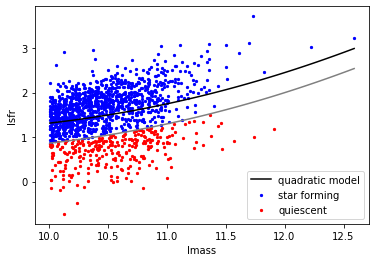

In [16]:
threshold_quiescent=0.45
y_pred = quad_model.predict(X)
quiescent_selection = (y<=y_pred-threshold_quiescent)

plt.scatter(X[:,0][~quiescent_selection], y[~quiescent_selection], s=5, color='blue', label='star forming')
plt.scatter(X[:,0][quiescent_selection], y[quiescent_selection], s=5, color='red', label='quiescent')
plt.plot(X_arr, y_pred_quad, color='black', label='quadratic model')
plt.plot(X_arr, y_pred_quad-threshold_quiescent, color='gray')
plt.legend()
plt.xlabel('lmass')
plt.ylabel('lsfr')

print('Quiescent fraction: {0:1.2f}'.format(quiescent_selection.sum()/quiescent_selection.shape[0]))

We can next use seaborn to make another joint plot, but this time we use our categorical variable to color code.

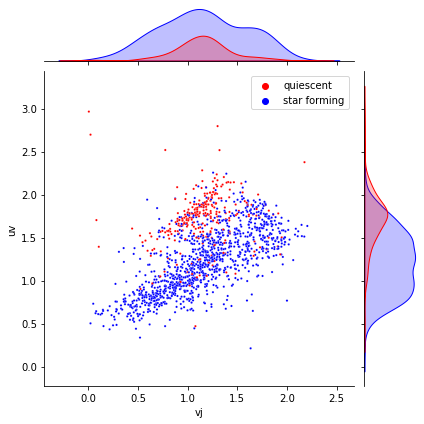

In [17]:
# We first define the following helper array for color coding
_hue=np.asarray(['star forming' for _ in range(len(full_df['lsfr']))])
_hue[quiescent_selection]='quiescent'

sns.jointplot(x=full_df['vj'], y=full_df['uv'], s=5, hue=_hue, palette=["red","blue"])

We now make a balanced subsample of two populations such that the number of quiescent and star forming galaxies are the same. This will help us avoid biasing some of our following models. Next, we define our training and test sets.

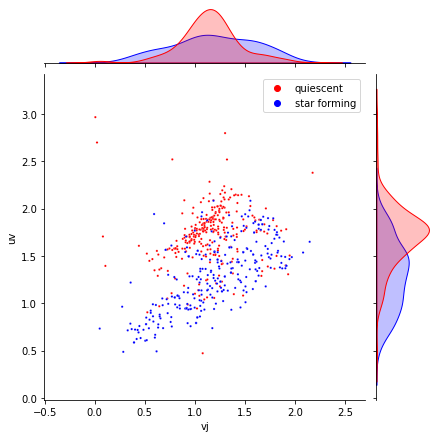

In [18]:
Y_ = np.ones_like(full_df['lsfr'])
Y_[quiescent_selection]=0

# We randomly pick star-forming galaxies,
# such that their total number is equal to the total number of quiescent galaxies
idx_selected=[i for i in np.arange(Y_.shape[0])[quiescent_selection]]
idx_sf = np.random.choice(np.arange(Y_.shape[0])[~quiescent_selection], size=quiescent_selection.sum()) 
idx_selected.extend(idx_sf.tolist())

Y_ = Y_[idx_selected]
X_ = np.vstack([full_df['vj'].to_numpy()[idx_selected], full_df['uv'].to_numpy()[idx_selected]]).T


# Plot the balanced subsample
__hue = np.asarray(['star forming' for _ in range(Y_.shape[0])])
__hue[Y_==0]='quiescent'
_plt_obj=sns.jointplot(x=X_[:,0], y=X_[:,1], s=5, hue=__hue, palette=["red","blue"])
_plt_obj.ax_joint.set_xlabel('vj')
_plt_obj.ax_joint.set_ylabel('uv')

# train/test splitting
X_train, X_test, y_train, y_test = train_test_split(X_, Y_, stratify=Y_)

At the next three parts, we fit Quadratic/Linear Discriminat models, a logistic regression and a random forest model to the data, trying to predict quiescent/star-forming galaxies using UV and VJ colors. As we will see, none of these models performs significantly better than the others in terms of F1 score or confusion matrix.

## I. Quadratic/Linear Discriminant Analysis

In [19]:
QDA_model = Pipeline([('scale', StandardScaler()), ('QDA_fit', QuadraticDiscriminantAnalysis())])
LDA_model = Pipeline([('scale', StandardScaler()), ('LDA_fit', LinearDiscriminantAnalysis())])

QDA_model.fit(X_train, y_train)
LDA_model.fit(X_train, y_train)

y_pred_LDA = LDA_model.predict(X_test)
y_pred_QDA = QDA_model.predict(X_test)

# We define baseline to be the model that assume all galaxies are star-forming
print('F1 score (LDA): {0:1.2f}'.format(f1_score(y_test, y_pred_LDA)))
print('F1 score (QDA): {0:1.2f}'.format(f1_score(y_test, y_pred_QDA)))
print('F1 score (baseline): {0:1.2f}\n'.format(f1_score(y_test, np.ones_like(y_test))))

print('Confusion matrix (LDA):')
print(confusion_matrix(y_test, y_pred_LDA))

print('\nConfusion matrix (QDA):')
print(confusion_matrix(y_test, y_pred_QDA))

F1 score (LDA): 0.81
F1 score (QDA): 0.80
F1 score (baseline): 0.66

Confusion matrix (LDA):
[[57 14]
 [13 57]]

Confusion matrix (QDA):
[[56 15]
 [13 57]]


## II. Logistic Regression

In [20]:
# We fit a logistic regression using second degree polynomials of uv and vj colors.
uvj_logistic_model = Pipeline([('poly_transform', PolynomialFeatures(degree=2, include_bias=False)),
                 ('logistic_fit', LogisticRegression())])

uvj_logistic_model.fit(X_train, y_train)
y_pred=uvj_logistic_model.predict(X_test)

print('F1 score (model): {0:1.2f}'.format(f1_score(y_test,y_pred)))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

F1 score (model): 0.81
Confusion matrix:
[[56 15]
 [12 58]]


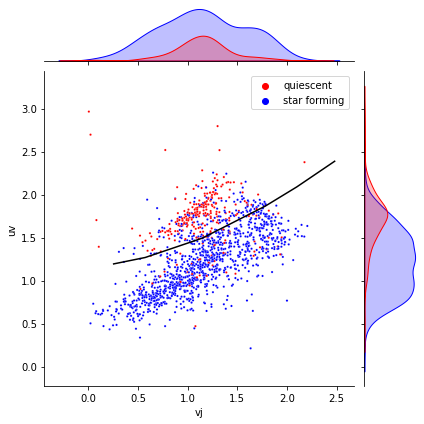

In [21]:
_plt_obj = sns.jointplot(x=full_df['vj'], y=full_df['uv'], s=5, hue=_hue, palette=["red","blue"])

_xmin, _xmax = _plt_obj.ax_joint.get_xlim()
_ymin, _ymax = _plt_obj.ax_joint.get_ylim()
_x1,_x2 = np.meshgrid(np.linspace(_xmin,_xmax, 50), np.linspace(_ymin,_ymax, 50))
X_arr=np.vstack([_x1.flatten(), _x2.flatten()]).T
y_arr = uvj_logistic_model.predict_proba(X_arr)
X_boundary=X_arr[np.abs(y_arr[:,0]-y_arr[:,1])<0.02]
_plt_obj.ax_joint.plot(X_boundary[:,0],X_boundary[:,1], color='black')

## III. Random Forest

In [22]:
random_forest_model = RandomForestClassifier()

random_forest_model.fit(X_train, y_train)
y_pred=random_forest_model.predict(X_test)

print('F1 score (model): {0:1.2f}'.format(f1_score(y_test,y_pred)))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

F1 score (model): 0.80
Confusion matrix:
[[53 18]
 [11 59]]


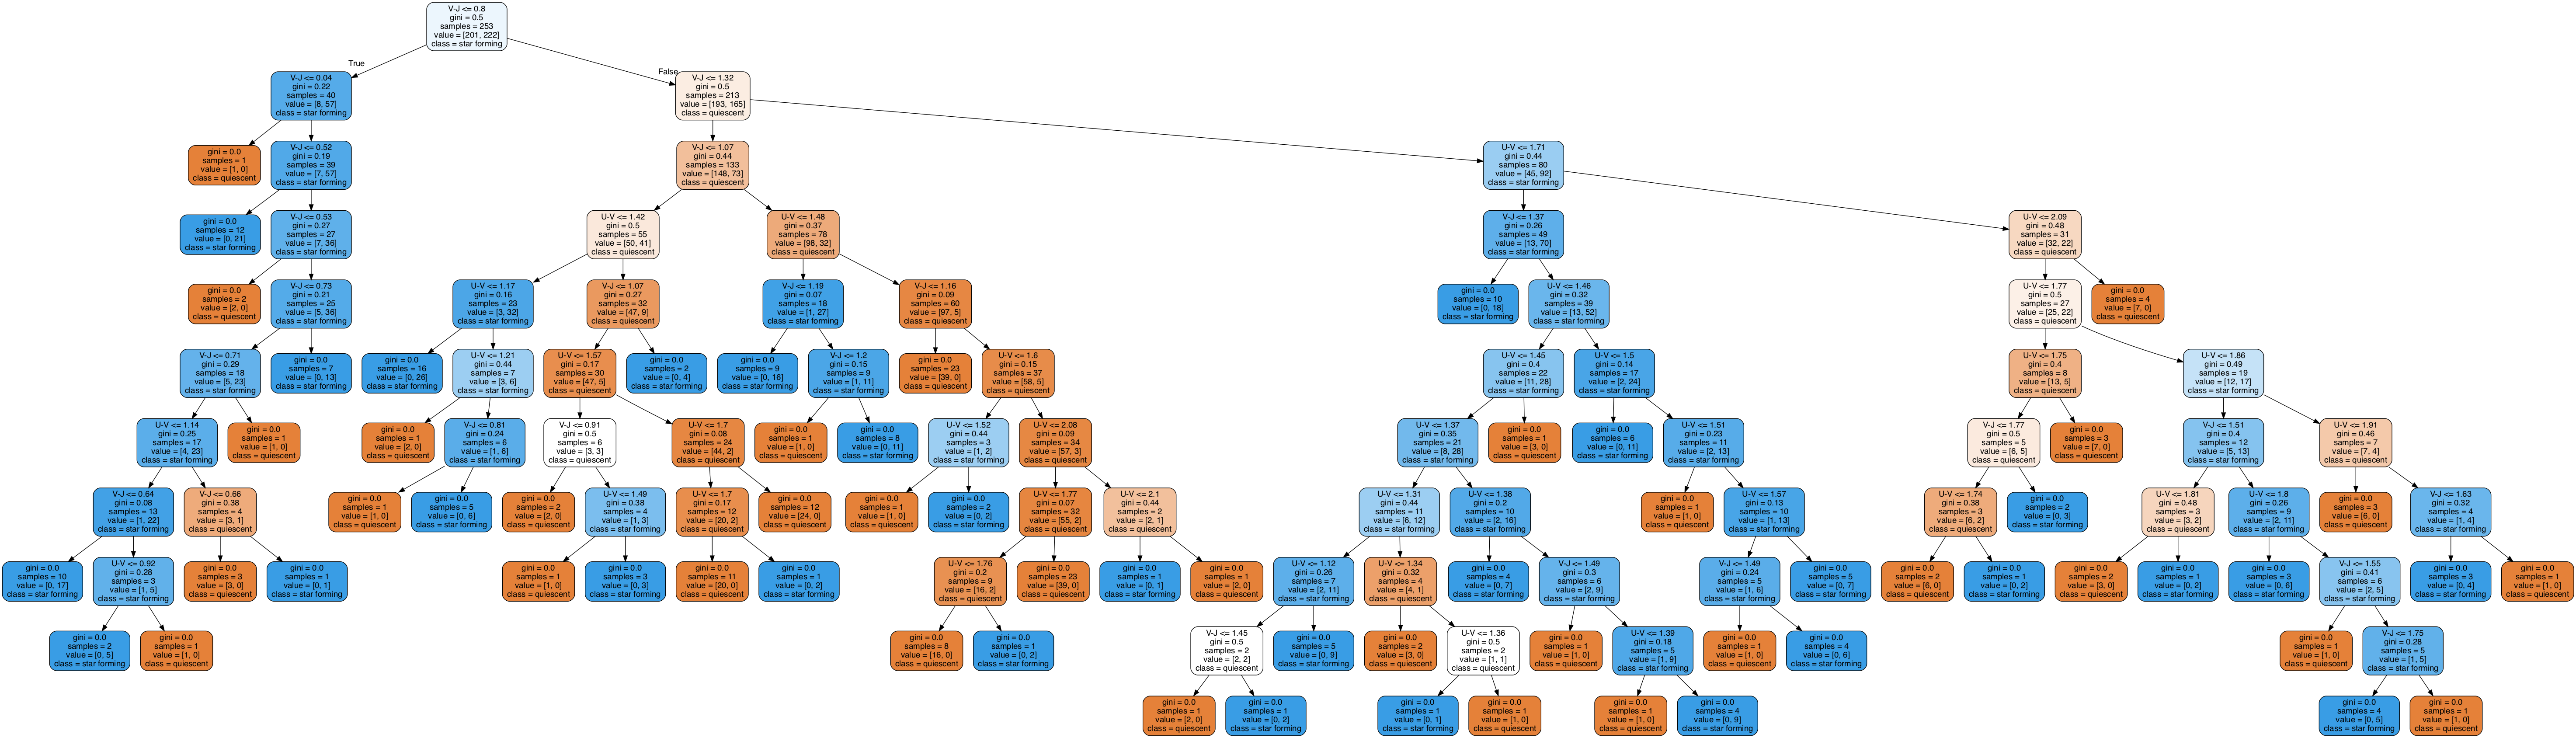

In [23]:
# We pick a random tree to visualize
tree = random_forest_model.estimators_[1]

export_graphviz(tree, out_file='tree.dot',  feature_names = ['V-J','U-V'], class_names = ['quiescent', 'star forming'],
                rounded = True, proportion = False, precision = 2, filled = True)

os.system('dot -Tpng ./tree.dot -o ./tree.png')
Image(filename = 'tree.png')

## IV. k-nearest neighbors 

In [24]:
kn_model = KNeighborsClassifier(n_neighbors=20)        
kn_model.fit(X_train, y_train)

y_pred=kn_model.predict(X_test)
print('F1 score (model): {0:1.2f}'.format(f1_score(y_test,y_pred)))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

F1 score (model): 0.81
Confusion matrix:
[[55 16]
 [11 59]]


## V. Effect of threshold
In this part, we take logistic regression as a model (since no model clearly stood out), and investigate the effect of threshold on F1 score. We can easily try out other models too. As we will see, choosing a different threshold for quiescent galaxies from star-formation/stellar mass correlation does not lead to a classification of galaxies (regressed on their UV/VJ colors) with a higher F1 score that is statistically significant. 

Text(0, 0.5, 'df1 score')

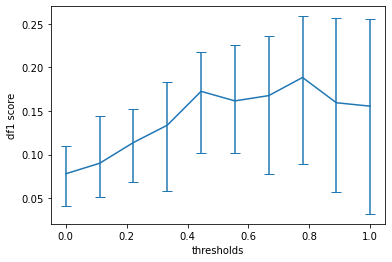

In [25]:
Nthresh = 10 # Number of threshold
Nboot = 100 # Number of balancing/train/test splitting iterations

F1_scores=np.zeros((Nthresh, Nboot))
thresholds = np.linspace(0,1.0,Nthresh)

for ith, threshold_quiescent in enumerate(thresholds):
    # define the quiescent population
    y_pred = quad_model.predict(X)
    quiescent_selection = (y<=y_pred-threshold_quiescent)
    
    # We do balancing and train/test splitting 100 times to estimate the uncertainty of F1
    for iiter in range(Nboot):
        # define the balanced subsample
        Y_ = np.ones_like(full_df['lsfr'])
        Y_[quiescent_selection]=0

        idx_selected=[i for i in np.arange(Y_.shape[0])[quiescent_selection]]
        idx_sf = np.random.choice(np.arange(Y_.shape[0])[~quiescent_selection], size=quiescent_selection.sum()) 
        idx_selected.extend(idx_sf.tolist())

        Y_ = Y_[idx_selected]
        X_ = np.vstack([full_df['vj'].to_numpy()[idx_selected], full_df['uv'].to_numpy()[idx_selected]]).T
    
        X_train, X_test, y_train, y_test = train_test_split(X_, Y_, stratify=Y_)
        
    
        _model_ = Pipeline([('poly_transform', PolynomialFeatures(degree=2, include_bias=False)),
                 ('logistic_fit', LogisticRegression(max_iter=10000))])
        
        _model_.fit(X_train, y_train)
        y_pred=_model_.predict(X_test)

        F1_scores[ith, iiter] = f1_score(y_test,y_pred) - f1_score(y_test, np.ones_like(y_test))

low_f1, med_f1, up_f1 = np.percentile(F1_scores, q=[2.5, 50, 97.5], axis=1)
plt.errorbar(thresholds, med_f1, yerr=[med_f1-low_f1, up_f1-med_f1], capsize=5)
plt.xlabel('thresholds')
plt.ylabel('df1 score')

## VI. Including all color-color combinations
In this part, we include every color combination and use (1) a random forest and (2) a simple neural net to fit the model. We compare the result with the random forest above, which was trained on U-V and V-J only. 

In [26]:
# This dictionary, taken from the comments on *.RF file, helps use better names for colors
color_dict={'L153': 'Johnson_U',
'L154': 'Johnson_B',
'L155': 'Johnson_V',
'L161': 'J',
'L162': 'H',
'L163': 'K',
'L156': 'SDSS_u',
'L157': 'SDSS_g',
'L158': 'SDSS_r',
'L159': 'SDSS_i',
'L160': 'SDSS_z',
'L135': 'Bessel_UX',
'L136': 'Bessel_B',
'L137': 'Bessel_V',
'L138': 'Bessel_R',
'L139': 'Bessel_I',
'L270': 'Tophat_1400_200',
'L271': 'Tophat_1700_200',
'L272': 'Tophat_2200_200',
'L273': 'Tophat_2700_200',
'L274': 'Tophat_2800_200',
'L275': 'Tophat_5500_200'}
full_df.rename(columns=color_dict, inplace=True)

# Add all color combinations to the data frame and a list, to be used in fitting.
# We have 22 colors in the dictinary above, so a total of 22*21/2=231 color combinations can be made.
# We also have a color-color subset here, which is the combination of colors we used in Sections I-V.
# We track them so we can compare new results with that of Section III.

color_color_subset=set([('Johnson_U', 'Johnson_V'), ('Johnson_V', 'J')])

subset_ids=[]
X_full=[]
for i, (c1, c2) in enumerate(combinations(color_dict.values(), 2)):
    full_df.loc[:, '{0}-{1}'.format(c1, c2)]=-2.5*np.log10(full_df[c1]/full_df[c2])
    X_full.append(full_df['{0}-{1}'.format(c1, c2)].to_numpy())
    
    if (c1, c2) in color_color_subset:
        subset_ids.append(i)

X_full=np.asarray(X_full)

In [27]:
# balance the data set, make the training and test sets
Y_ = np.ones_like(full_df['lsfr'])
Y_[quiescent_selection]=0

Y_ = Y_[idx_selected]
X_ = X_full[:, idx_selected].T

X_train, X_test, y_train, y_test = train_test_split(X_, Y_, stratify=Y_)
X_train_subset = X_train[:, subset_ids]*1.0
X_test_subset = X_test[:, subset_ids]*1.0

In [28]:
# random forest model, on full color-color set
random_forest_model = Pipeline([('scale', StandardScaler()) , ('random_forest', RandomForestClassifier())])

random_forest_model.fit(X_train, y_train)
y_pred=random_forest_model.predict(X_test)

print('F1 score (model): {0:1.2f}'.format(f1_score(y_test,y_pred)))
print('F1 score (baseline): {0:1.2f}\n'.format(f1_score(y_test, np.ones_like(y_test))))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

F1 score (model): 0.83
F1 score (baseline): 0.66

Confusion matrix:
[[18  2]
 [ 4 15]]


In [29]:
# random forest model, on the subset of color-color set. This is the exact same model as Section III, 
# but it is trained on new training set, to be fully consistent with the random forest above
random_forest_model = Pipeline([('scale', StandardScaler()) , ('random_forest', RandomForestClassifier())])

random_forest_model.fit(X_train_subset, y_train)
y_pred=random_forest_model.predict(X_test_subset)

print('F1 score (model): {0:1.2f}'.format(f1_score(y_test,y_pred)))
print('F1 score (baseline): {0:1.2f}\n'.format(f1_score(y_test, np.ones_like(y_test))))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

F1 score (model): 0.80
F1 score (baseline): 0.66

Confusion matrix:
[[18  2]
 [ 5 14]]


In [30]:
# a simple Neural net fit
NN_model = Pipeline([('scale', StandardScaler()) , 
                     ('random_forest', MLPClassifier(solver='sgd', max_iter=10000))])

NN_model.fit(X_train, y_train)
y_pred=NN_model.predict(X_test)

print('F1 score (model): {0:1.2f}'.format(f1_score(y_test,y_pred)))
print('F1 score (baseline): {0:1.2f}\n'.format(f1_score(y_test, np.ones_like(y_test))))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

F1 score (model): 0.83
F1 score (baseline): 0.66

Confusion matrix:
[[18  2]
 [ 4 15]]
